# Using Machine Learning to Combat Financial Fraud

Credit card fraud poses significant financial risks, with projected global losses estimated to reach $43 billion by 2026. It is crucial to employ robust methods to combat credit fraud due to the potential for substantial economic losses, damage to individuals' financial well-being, and the threat to the overall stability and trust in financial systems. Preventing and addressing credit fraud is vital for safeguarding both individuals and the global economy.

Seeing that one bank "struggled with a low 40 percent fraud detection rate and was managing up to 1,200 false positives per day—and 99.5 percent of all cases the bank was investigating were not fraud related. That large number of false alarms required a substantial investment of people, time, and money to investigate what turned out to be dead ends." proved just how important and costly this problem is.

Having found the dataset online I thought thought this would be an interesting project to work through.


In [186]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Set additional options
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

### 1. Load Data

Data was found on kaggle here: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022/data

The Bank Account Fraud (BAF) suite of datasets has been published at NeurIPS 2022 and it comprises a total of 6 different synthetic bank account fraud tabular datasets. BAF is a realistic, complete, and robust test bed to evaluate novel and existing methods in ML and fair ML, and the first of its kind!

This suite of datasets is:

* Realistic, based on a present-day real-world dataset for fraud detection;
* Biased, each dataset has distinct controlled types of bias;
* Imbalanced, this setting presents a extremely low prevalence of positive class;
* Dynamic, with temporal data and observed distribution shifts;
* Privacy preserving, to protect the identity of potential applicants we have applied differential privacy techniques (noise addition), feature encoding and trained a generative model (CTGAN).


Each dataset is composed of:

* 1 million instances;
* 30 realistic features used in the fraud detection use-case;
* A column of “month”, providing temporal information about the dataset;
* Protected attributes, (age group, employment status and % income).

In [187]:
# Import Data
raw_data = pd.read_csv(r"C:\Users\e014694\OneDrive - Telstra\Documents\Git\Fraudulent_payments\Data\Base.csv")

raw_data.head()

raw_dataa = raw_data

In [188]:
# Check the distribution of fraud cases 
fraud_counts = pd.DataFrame(raw_data['fraud_bool'].value_counts()).reset_index()
fraud_counts

,fraud_bool,count
0,0,988971
1,1,11029


As with most fraud data sets, it can be seen the data is heavily 'imbalanced'. Where a tiny proportion of the data is actually positive and and even distribution is not seen. This will be addressed later.

Visualising the size of the imbalance...

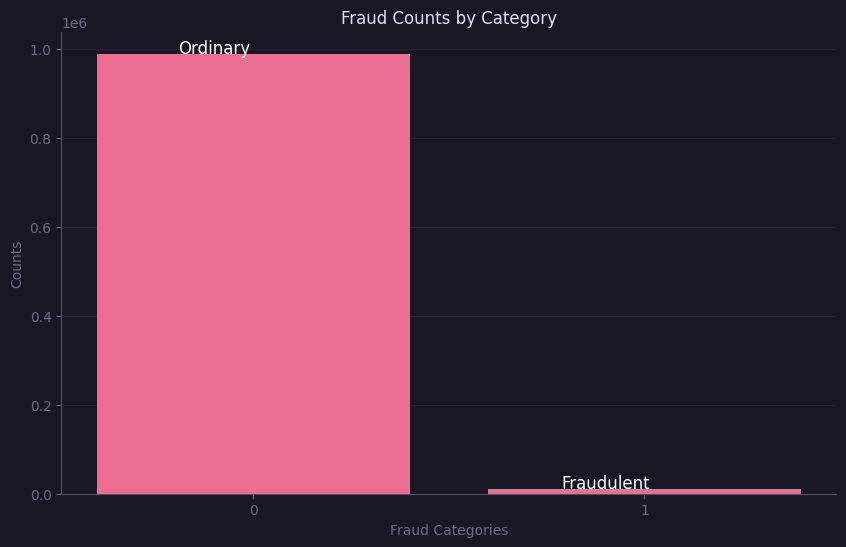

In [189]:
plt.style.use('rose-pine') # Choose plot ftyle to be used

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bars = plt.bar(fraud_counts['fraud_bool'], fraud_counts['count'])
plt.xlabel('Fraud Categories')
plt.ylabel('Counts')
plt.title('Fraud Counts by Category')

labels = ['Ordinary', 'Fraudulent']

# Add custom labels to the bars
for bar, label in zip(bars, labels):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, label, ha='center', color='white', fontsize=12)

# Customize the x-axis tick labels
plt.xticks([0, 1], ['0', '1'])

# Show the chart
plt.show()

---

### 2. Data Preparation

Data preprocessing is a critical step in machine learning because it ensures that the data used for modeling is of high quality and suitable for analysis. It involves tasks like cleaning, transforming, and organizing data to make it more effective for machine learning algorithms. 

In [190]:
raw_data.head(5).T

,0,1,2,3,4
fraud_bool,1,1,1,1,1
income,0.90,0.90,0.90,0.90,0.90
name_email_similarity,0.17,0.30,0.04,0.16,0.60
prev_address_months_count,-1,-1,-1,-1,-1
current_address_months_count,88,144,132,22,218
customer_age,50,50,40,50,50
days_since_request,0.02,0.01,3.11,0.02,0.00
intended_balcon_amount,-1.33,-0.82,-0.76,-1.21,-0.77
payment_type,AA,AB,AC,AB,AB
zip_count_4w,769,366,870,810,890


In [191]:
raw_data.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00
mean,0.01,0.56,0.49,16.72,86.59,33.69,1.03,8.66,1572.69,5665.30,4769.78,4856.32,184.36,9.50,130.99,0.53,0.42,0.89,10.84,0.22,515.85,0.03,7.54,0.58,1.02,0.00,3.29
std,0.10,0.29,0.29,44.05,88.41,12.03,5.38,20.24,1005.37,3009.38,1479.21,919.84,459.63,5.03,69.68,0.50,0.49,0.31,12.12,0.42,487.56,0.16,8.03,0.49,0.18,0.00,2.21
min,0.00,0.10,0.00,-1.00,-1.00,10.00,0.00,-15.53,1.00,-170.60,1300.31,2825.75,0.00,0.00,-170.00,0.00,0.00,0.00,-1.00,0.00,190.00,0.00,-1.00,0.00,-1.00,0.00,0.00
25%,0.00,0.30,0.23,-1.00,19.00,20.00,0.01,-1.18,894.00,3436.37,3593.18,4268.37,1.00,6.00,83.00,0.00,0.00,1.00,-1.00,0.00,200.00,0.00,3.10,0.00,1.00,0.00,1.00
50%,0.00,0.60,0.49,-1.00,52.00,30.00,0.02,-0.83,1263.00,5319.77,4749.92,4913.44,9.00,9.00,122.00,1.00,0.00,1.00,5.00,0.00,200.00,0.00,5.11,1.00,1.00,0.00,3.00
75%,0.00,0.80,0.76,12.00,130.00,40.00,0.03,4.98,1944.00,7680.72,5752.57,5488.08,25.00,13.00,178.00,1.00,1.00,1.00,25.00,0.00,500.00,0.00,8.87,1.00,1.00,0.00,5.00
max,1.00,0.90,1.00,383.00,428.00,90.00,78.46,112.96,6700.00,16715.57,9506.90,6994.76,2385.00,39.00,389.00,1.00,1.00,1.00,32.00,1.00,2100.00,1.00,85.90,1.00,2.00,0.00,7.00


### 2.1 Data Skewness

Skewwnes: Skewness is the degree of asymmetry observed in a distribution. Distributions can exhibit right (positive) skewness or left (negative) skewness to varying degrees. A normal distribution (bell curve) exhibits zero skewness.

Skewed data can have an adverse impact when modelling as the data points are not distruted through the range in an even manor. [improve]

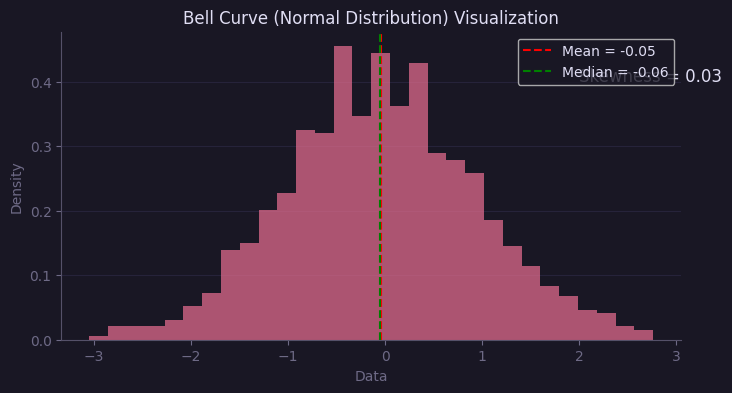

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate a sample dataset with a bell curve (normal distribution)
np.random.seed(0)
mean = 0  # Mean of the normal distribution
std_dev = 1  # Standard deviation of the normal distribution
data = np.random.normal(mean, std_dev, size=1000)  # Example dataset with a bell curve

# Create a DataFrame
df = pd.DataFrame({'Data': data})

# Create a histogram to visualize skewness
plt.figure(figsize=(8, 4))
plt.hist(df['Data'], bins=30, density=True, alpha=0.7)
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('Bell Curve (Normal Distribution) Visualization')

# Calculate skewness
skewness = df['Data'].skew()
plt.axvline(x=df['Data'].mean(), color='red', linestyle='--', label=f'Mean = {df["Data"].mean():.2f}')
plt.axvline(x=df['Data'].median(), color='green', linestyle='--', label=f'Median = {df["Data"].median():.2f}')
plt.legend()
plt.text(2, 0.4, f'Skewness = {skewness:.2f}', fontsize=12)

plt.show()


Above is an example of what a normally distributed data set could look like. Where the mean and median are in the middle of the distribution.

Below is one column that displays highly skewed data and how a log transformation can aid to rectify this.

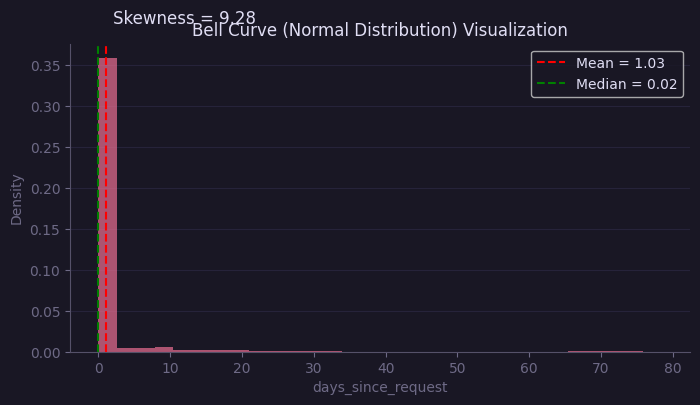

In [193]:
# Create a histogram to visualize skewness
plt.figure(figsize=(8, 4))
plt.hist(raw_data['days_since_request'], bins=30, density=True, alpha=0.7)
plt.xlabel('days_since_request')
plt.ylabel('Density')
plt.title('Bell Curve (Normal Distribution) Visualization')

# Calculate skewness
skewness = raw_data['days_since_request'].skew()
plt.axvline(x=raw_data['days_since_request'].mean(), color='red', linestyle='--', label=f'Mean = {raw_data["days_since_request"].mean():.2f}')
plt.axvline(x=raw_data['days_since_request'].median(), color='green', linestyle='--', label=f'Median = {raw_data["days_since_request"].median():.2f}')
plt.legend()
plt.text(2, 0.4, f'Skewness = {skewness:.2f}', fontsize=12)

plt.show()

Visualising the 'days_since_request' field shows how non-normal distribution may look. To remedy this a log function can be used to improve the distrubtion for our purposes.

As can be seen in the graph, applying a log10 function to the field has improved the skew of the data. Reducing the skew score from 9.28 to 1.61, roughly a 9x improvement in skew. This will support the model in assessing the impact the variation of these fields have on the output.

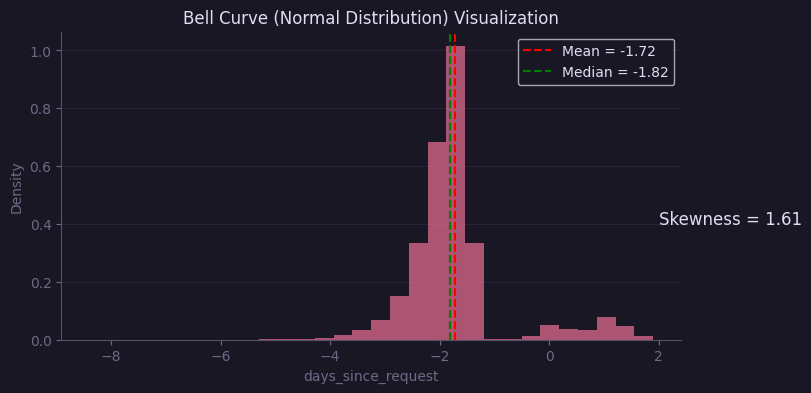

In [194]:
test_field = np.log10(raw_data['days_since_request']) # Apply log funsction to chosen field

# Create a histogram to visualize skewness
plt.figure(figsize=(8, 4))
plt.hist(test_field, bins=30, density=True, alpha=0.7)
plt.xlabel('days_since_request')
plt.ylabel('Density')
plt.title('Bell Curve (Normal Distribution) Visualization')

# Calculate skewness
skewness = test_field.skew()
plt.axvline(x=test_field.mean(), color='red', linestyle='--', label=f'Mean = {test_field.mean():.2f}')
plt.axvline(x=test_field.median(), color='green', linestyle='--', label=f'Median = {test_field.median():.2f}')
plt.legend()
plt.text(2, 0.4, f'Skewness = {skewness:.2f}', fontsize=12)

plt.show()

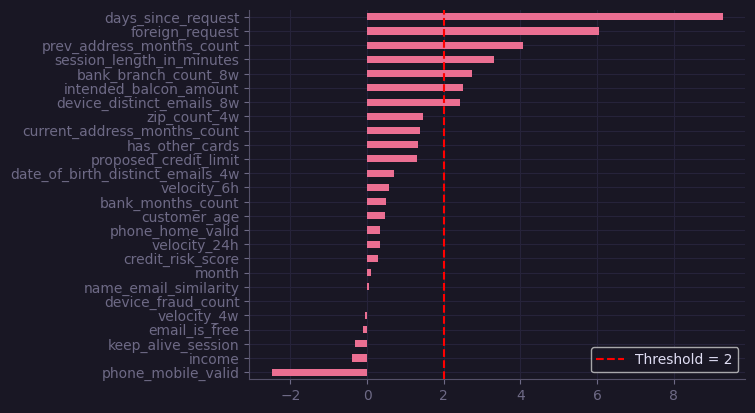

In [195]:
numeric_columns = raw_data.drop(columns = 'fraud_bool').select_dtypes(include=['int64', 'float64']) # Specify numeric columns, removing fradu_bool as that is the y-variable

raw_data[numeric_columns.columns].skew(numeric_only=True).sort_values().plot(kind = 'barh') # Find the skew of each feature and plot of horizontal bar plot

plt.axvline(x=2, color='red', linestyle='--', label='Threshold = 2') # Add a threshold line at 2
plt.legend()

c:\Users\e014694\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


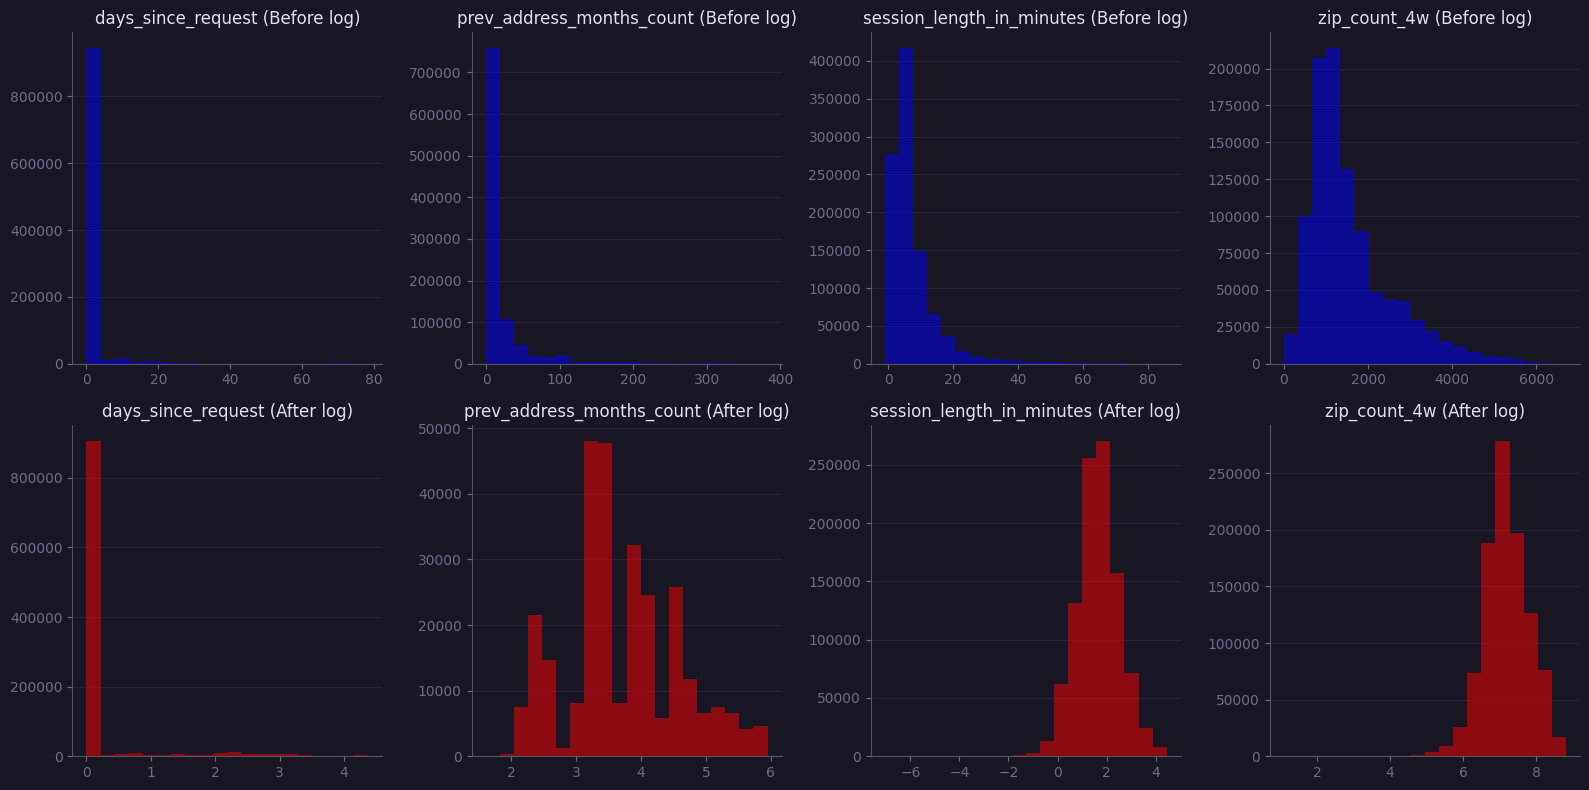

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# List of columns to apply log10 to
columns_to_log = ['days_since_request', 'prev_address_months_count', 'session_length_in_minutes', 'zip_count_4w']

# Create a figure with subplots for each column
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# Cycle through each column and plot the original and below it the log of the column
for i, column in enumerate(columns_to_log):
    # Plot the histogram before applying log10 (top row)
    axes[0, i].hist(raw_data[column], bins=20, color='blue', alpha=0.5, label='Before log10')
    axes[0, i].set_title(f'{column} (Before log)')

    # Plot the histogram after applying log10 (bottom row)
    log_transformed_data = np.log(raw_data[column] +raw_data[column].min() + 1)  # Add minimum value + 1 to ensure no negative or 0 values
    axes[1, i].hist(log_transformed_data, bins=20, color='red', alpha=0.5, label='After log')
    axes[1, i].set_title(f'{column} (After log)')


plt.tight_layout()
plt.show()


Distribution for last three have improved. Not concerned about the 'non-zero' centre as will standardise data set in the next step.

However days_since_request is still looking very skewed, can try a boxcox transform.

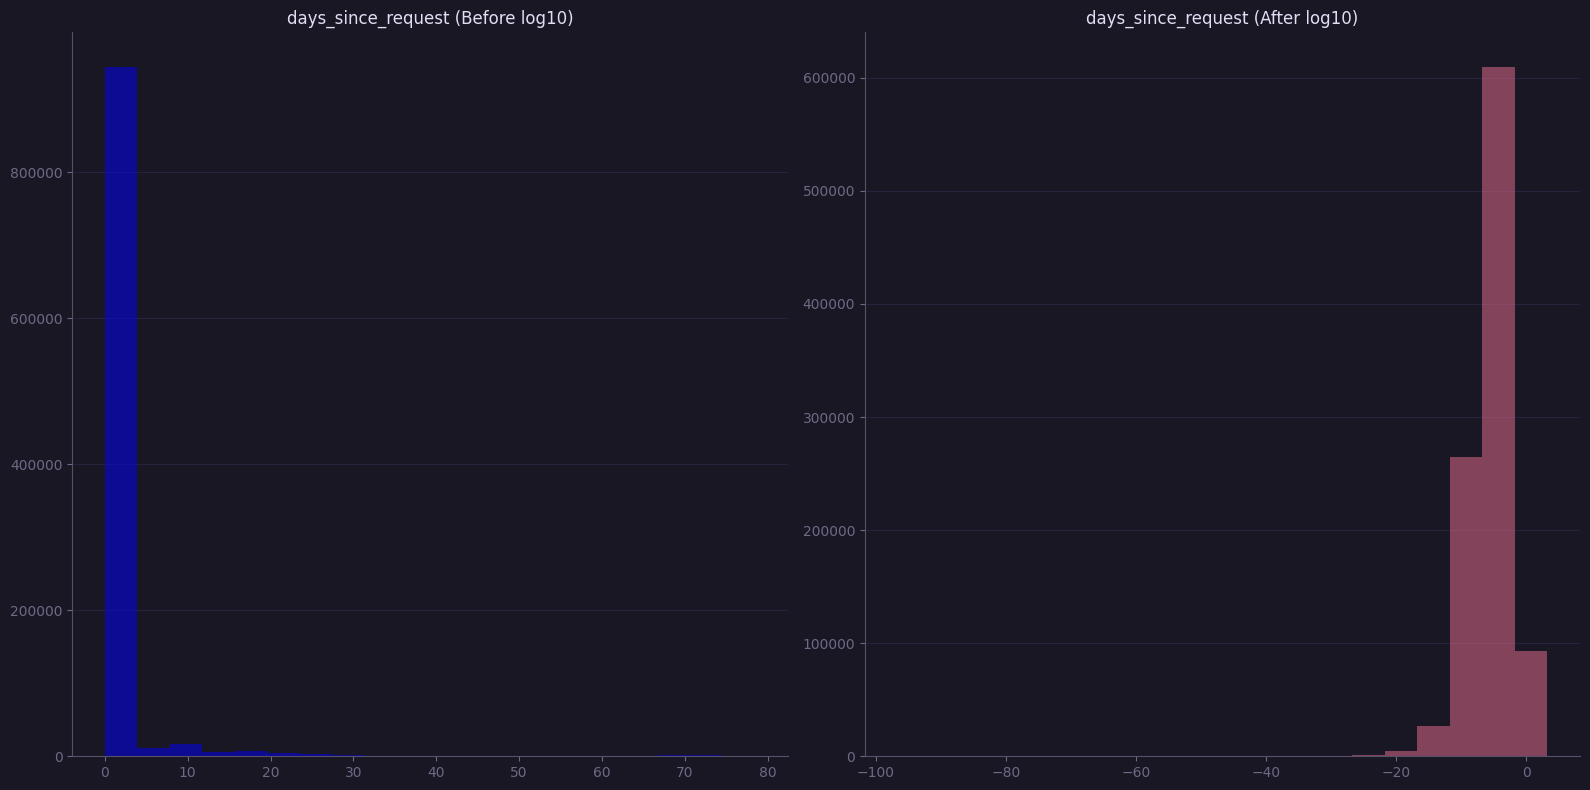

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# List of columns to apply log10 to
columns_to_log = ['days_since_request']

# Create a figure with subplots for each column
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for i, column in enumerate(columns_to_log):
    # Plot the histogram before applying log10 (top row)
    axes[0].hist(raw_data[column], bins=20, color='blue', alpha=0.5, label='Before log10')
    axes[0].set_title(f'{column} (Before log10)')

    # Plot the histogram after applying log10 (bottom row)
    transformed_data, lambda_ = stats.boxcox(raw_data[column])  # Adding 1 to avoid log(0)
    axes[1].hist(transformed_data, bins=20, alpha=0.5, label='After log10')
    axes[1].set_title(f'{column} (After log10)')


plt.tight_layout()
plt.show()

This has improved the distribution to a point that should work better for the models. Skew shouldn't impact random forrest models too much, but could cause issues for others.

In [198]:
# Apply a transformation to the features that were over the threshold
raw_data['boxcox_days_since_request'],lambda_ = stats.boxcox(raw_data['days_since_request'])
raw_data['log_prev_address_months_count'] = np.log1p(raw_data['prev_address_months_count'] + raw_data[column].min() + 1)
raw_data['log_session_length_in_minutes'] = np.log1p(raw_data['session_length_in_minutes'] + raw_data[column].min() + 1)
raw_data['log_zip_count_4w'] = np.log1p(raw_data['zip_count_4w']  + raw_data[column].min() + 1)



In [199]:
# Drop the original columns
raw_data.drop(columns = ['days_since_request','prev_address_months_count','session_length_in_minutes'], inplace = True)

In [200]:
# Find NaN values in the DataFrame
nan_values = raw_data.isna()

# Count NaN values in each column
nan_count = nan_values.sum()

# Locate rows with NaN values
nan_locations = raw_data[nan_values.any(axis=1)]

In [201]:
# Display the number of nan values descending, these should all be 0
nan_count.sort_values(ascending=False).head(3)

fraud_bool                       0
phone_home_valid                 0
log_session_length_in_minutes    0
dtype: int64

In [202]:
# Find inf values in the DataFrame
inf_values = np.isinf(raw_data.drop(columns = 'fraud_bool').select_dtypes(include=['int64', 'float64']))

# Count inf values in each column
inf_count = inf_values.sum()

# Locate rows with inf values
inf_locations = raw_data[inf_values.any(axis=1)]

In [203]:
# Display the number of inf values descending, these should all be 0
inf_count.sort_values(ascending=False).head(3)

income                           0
phone_mobile_valid               0
log_session_length_in_minutes    0
dtype: int64

### 2.2 Data standadisation

The data can be broken into 4 groups:

* Target Column - This is the column indicating fraud or not
* Numeric Columns - These columns hold continous numeric data, like Age, Income or Number of Months.
* Numeric (Binary) - This is a subset of the Numeric columns that are just filled with 1s & 0s indicating the answer to a Yes or No questions. Such as, is the phone number valid?
* Non Numeric - These are categorical columns where the data response is not a number. Such as what is the Operating system? Windows, OS, Linux.

Numeric columns require a scaling to be applied to them to ensure the values are standardised. Large variations in the data can impair model performance. For poorly distibuted data a logarithmic function can be applied to improve the data distribution. Sci-Kit Learn's MinMaxScaler is used here to format the numeric data here between 0 & 1. Other variations can scale data between -1 & 1.

Numeric binary doesn't need any pre-processing and can remain.

Non-Numeric, or categorical, require One-hot encoding. This is a technique used in data preprocessing and feature engineering, primarily in the context of machine learning and data analysis. It's employed to represent categorical variables as binary vectors (0s and 1s). Each category or label within a categorical variable is transformed into a binary feature, where each feature corresponds to one category and is either "on" (1) or "off" (0) based on whether the original data point falls into that category.

In [209]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Split the DataFrame into the target column, numeric, and non-numeric columns
target_column = raw_data['fraud_bool']
numeric_columns = raw_data.drop(columns = 'fraud_bool').select_dtypes(include=['int64', 'float64'])
non_numeric_columns = raw_data.select_dtypes(exclude=['int64', 'float64'])

# Identify and filter out columns with just 0s and 1s
non_std_columns = []
for column in numeric_columns.columns:
    unique_values = numeric_columns[column].unique()
    if len(unique_values) > 2 or not all(val in {0, 1} for val in unique_values):
        non_std_columns.append(column)

#bool columns
binary_columns = numeric_columns.drop(columns = non_std_columns)

# numeric Columns
numeric_columns = numeric_columns.drop(columns = binary_columns)


# Apply one-hot encoding to non-numeric columns
non_numeric_encoded = pd.get_dummies(non_numeric_columns)

# Initialize the MinMaxScaler with a specific range (e.g., 0 to 1)
scaler = MinMaxScaler(feature_range=(0, 1))
numeric_scaled = pd.DataFrame(scaler.fit_transform(numeric_columns), columns=numeric_columns.columns)

# Concatenate the target column, non-numeric columns, and scaled numeric columns
processed_data = pd.concat([
                            target_column,
                            non_numeric_encoded,
                            binary_columns, 
                            numeric_scaled], axis=1)

# Now, processed_data contains the target column, non-numeric columns, and scaled numeric columns (excluding 0s and 1s columns).
processed_data

,fraud_bool,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,keep_alive_session,device_fraud_count,income,name_email_similarity,current_address_months_count,customer_age,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,device_distinct_emails_8w,month,boxcox_days_since_request,log_prev_address_months_count,log_session_length_in_minutes,log_zip_count_4w
0,1,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,0,1,0,0,0,0,0,1.00,0.17,0.21,0.50,0.11,0.11,0.64,0.22,0.25,0.00,0.15,0.64,0.76,0.16,0.67,1.00,0.92,0.00,0.40,0.72
1,1,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,1,0,0,0,0,0,0,1.00,0.30,0.34,0.50,0.11,0.05,0.04,0.17,0.07,0.30,0.08,0.77,0.48,0.69,0.67,1.00,0.89,0.00,0.79,0.62
2,1,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,1,0,1,0,0,0,0,1.00,0.04,0.31,0.38,0.11,0.13,0.25,0.19,0.08,0.00,0.36,0.62,0.00,0.01,0.67,1.00,0.98,0.00,0.43,0.74
3,1,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,1,0,1,1,0,0,0,1.00,0.16,0.05,0.50,0.11,0.12,0.21,0.34,0.05,0.81,0.15,0.50,0.97,0.01,0.67,1.00,0.91,0.00,0.31,0.73
4,1,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,1,1,0,0,0,1,0,1.00,0.60,0.51,0.50,0.11,0.13,0.31,0.17,0.06,0.83,0.05,0.83,0.97,0.69,0.67,1.00,0.89,0.00,0.39,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,1,1,1,0,0,1,0,0.63,0.19,0.24,0.38,0.11,0.12,0.48,0.86,0.51,0.00,0.21,0.44,0.79,0.01,0.67,0.57,0.92,0.00,0.53,0.73
999996,0,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,1,1,1,0,0,0,0,0.88,0.32,0.02,0.50,0.11,0.49,0.33,0.45,0.53,0.00,0.05,0.58,0.00,0.01,0.67,0.57,0.97,0.84,0.54,0.91
999997,0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,0,0,1,0,0,0,0,0.88,0.88,0.07,0.12,0.39,0.23,0.49,0.53,0.37,0.85,0.15,0.42,0.36,0.01,0.67,0.57,0.91,0.00,0.52,0.81
999998,0,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,0,1,0,0,0,1,0,1.00,0.76,0.44,0.12,0.86,0.21,0.49,0.33,0.38,0.70,0.15,0.60,0.88,0.16,0.67,0.57,0.91,0.00,0.41,0.80


---

## 3. Sampling correction

Seen below, the number of fraud instances compared to non-fraud is extremely small. This is common among many different Machine Learning problems including Fraud Detection, Loan Defaulting Predictions and Insurance Claim Predictions. 

This in called Imbalanced Classification, where the dataset (and expected outcomes) are vastly disproportionate. Regular Machine Learning models struggle with this as they are designed for datasets with more balanced outcomes.

There are a number of ways to combat this:
- Gathering more data
- Differing sampling techniques
- Changing models
- Generating synthetic data

For this problem synthetic data will be generated to provide a data set that has more fraud outcomes. A risk of this is the assumption on the generated data posseing the same trends and nuances as the original data. This can be addressed in the evaluation of performance.

### Example: Customer Age

Seen below, the vast difference in the amount of instances in non-fraud to fraud. This makes is extremely hard for the algorithm to make correct predictions.

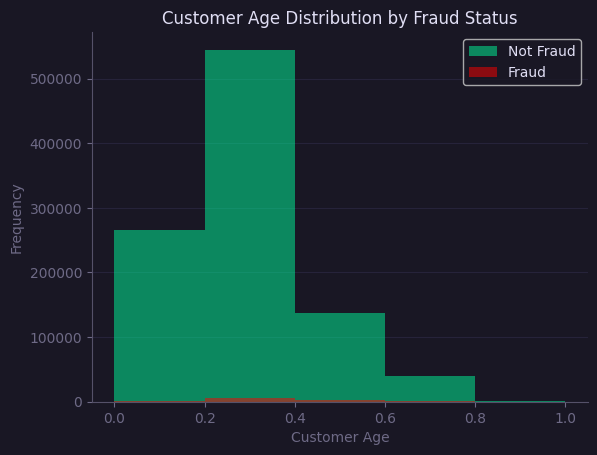

In [205]:
# Create a histogram plot
plt.hist([age for age, is_fraud in zip(processed_data['customer_age'], processed_data['fraud_bool']) if is_fraud == 0], 
         bins=5, alpha=0.5, label='Not Fraud', color='mediumspringgreen')
plt.hist([age for age, is_fraud in zip(processed_data['customer_age'], processed_data['fraud_bool']) if is_fraud == 1], 
         bins=5, alpha=0.5, label='Fraud', color='red')

# Add labels and title
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.title('Customer Age Distribution by Fraud Status')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Synthetic Minority Over-sampling Technique

As the name suggests, SMOTE is an oversampling method. It works by creating synthetic samples from the minority class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances. This process can be seen below where additional orange squares are produced.

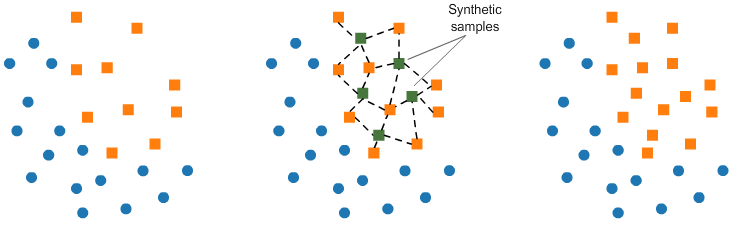

In [210]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.8, random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(processed_data.drop(columns='fraud_bool'), processed_data['fraud_bool'])

print('Distribution of label values before applying SMOTE:\n',pd.Series(processed_data['fraud_bool']).value_counts())
print('Distribution of label values after applying SMOTE:\n',pd.Series(y_train_smote).value_counts())

Distribution of label values before applying SMOTE:
 fraud_bool
0    988971
1     11029
Name: count, dtype: int64
Distribution of label values after applying SMOTE:
 fraud_bool
0    988971
1    791176
Name: count, dtype: int64


After applying SMOTE the dataset now has a more even distibution. This can got upto and over 50-50, but a smaller ratio was chosen to limit the amount of synthetic samples being made.

In [95]:
# Combine SMOTE outputs into on df
dataset_SMOTE = X_train_smote
dataset_SMOTE['fraud_bool'] = y_train_smote

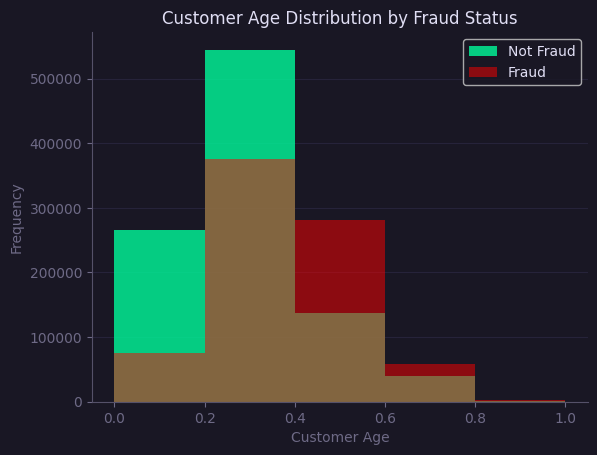

In [96]:
# Create a histogram plot
plt.hist([age for age, is_fraud in zip(dataset_SMOTE['customer_age'], dataset_SMOTE['fraud_bool']) if is_fraud == 0], 
         bins=5, alpha=0.8, label='Not Fraud', color='mediumspringgreen')
plt.hist([age for age, is_fraud in zip(dataset_SMOTE['customer_age'], dataset_SMOTE['fraud_bool']) if is_fraud == 1], 
         bins=5, alpha=0.5, label='Fraud', color='red')

# Add labels and title
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.title('Customer Age Distribution by Fraud Status')

# Add a legend
plt.legend()

# Show the plot
plt.show()

The histogram shows a significant increase in the fraud category. This is a result of the syntetic data that has been create using SMOTE. Impact across the full dataset can be seen below.

Ideally would use SMOTENC which factors in categorical features but the dataset grew too large.

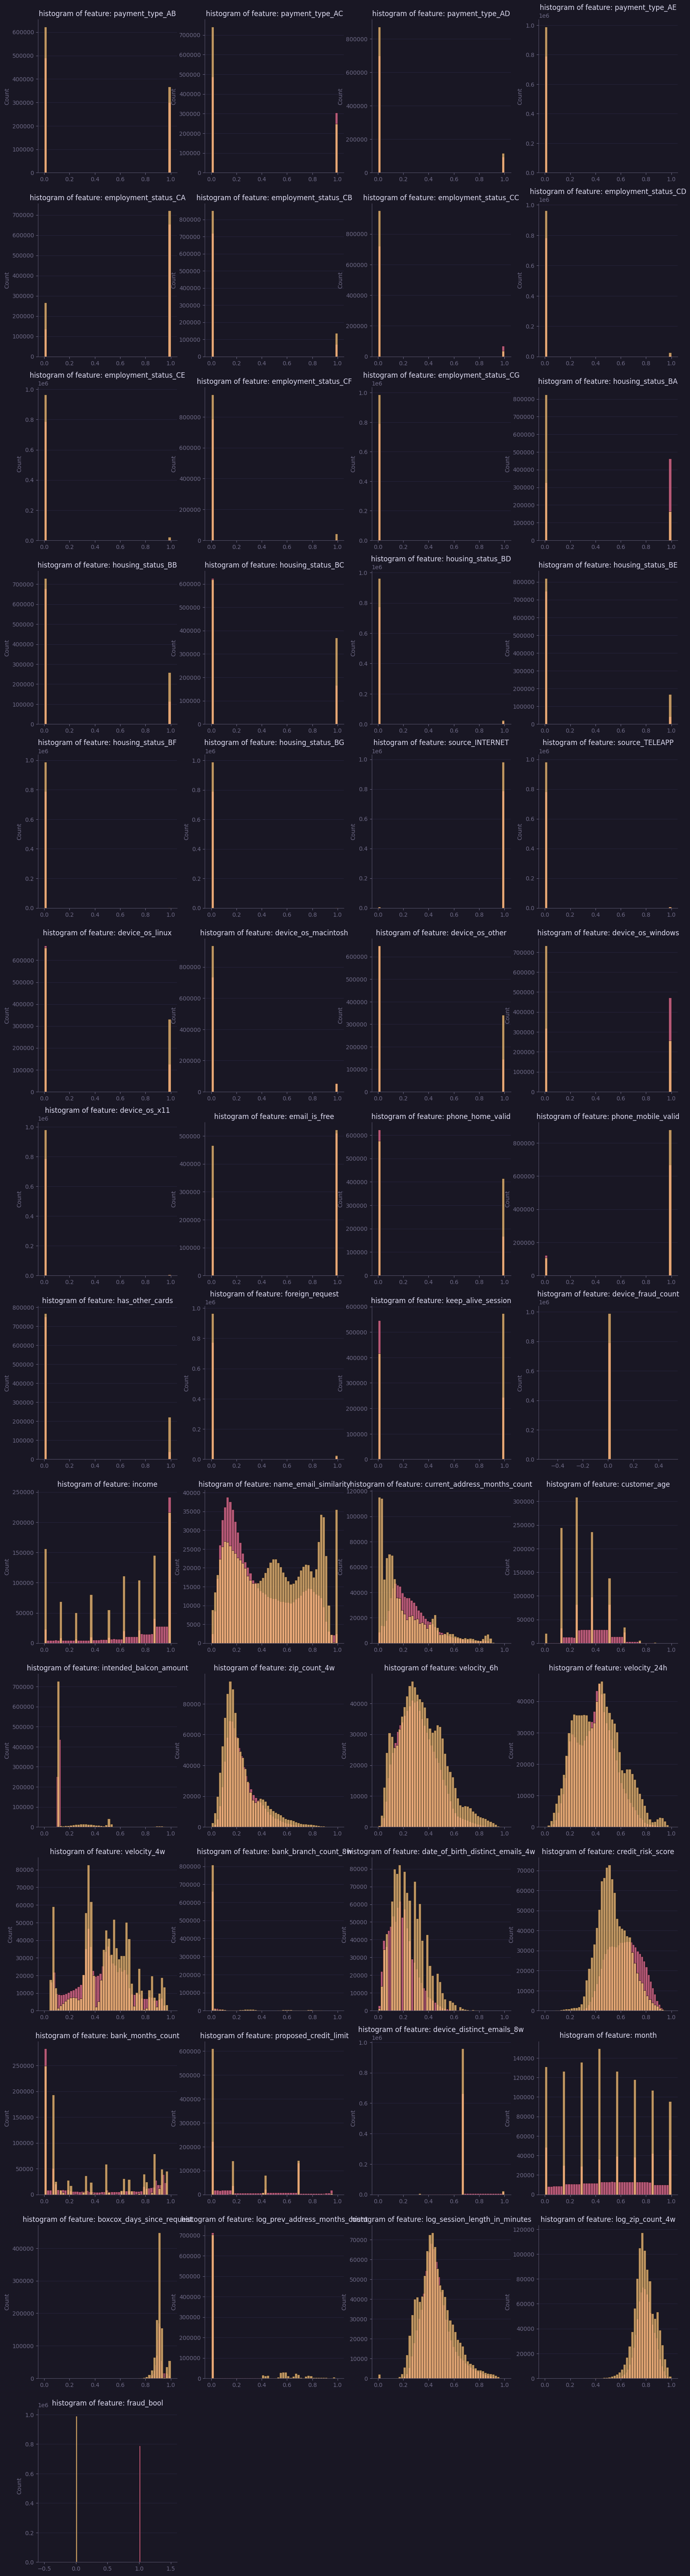

In [218]:
from matplotlib import gridspec
import seaborn as sns


# Plot each feature distibution seperated by fraud and non-fraud
plt.figure(figsize=(20,80))
gs = gridspec.GridSpec(14, 4)
for i, c in enumerate(dataset_SMOTE):
    ax = plt.subplot(gs[i])
    sns.histplot(dataset_SMOTE[c][dataset_SMOTE.fraud_bool == 1], bins=50)
    sns.histplot(dataset_SMOTE[c][dataset_SMOTE.fraud_bool == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(c))
plt.show()

-----

## 4. Feature Selection

### 4.1 Feature Correlation

Having cleaned, adjusted and scaled all of the features within the dataset it is now time to see which of these contribute the most to determining is a transaction is fraudulent or not.

Feature selection in machine learning is important because it:

* Improves Model Performance: By focusing on relevant features, it reduces overfitting and enhances model accuracy.
* Simplifies Models: It makes models easier to understand and interpret.
* Reduces Training Time: Fewer features mean quicker model training.
* Enhances Generalization: Models generalize better to new data.
* Improves Model Robustness: Models are more reliable and consistent.

To begin deciding what features to keep correlation is assessed between each feature. When features within a dataset correlate too much, it can be indicating some causal-relationship, negaitivley impact the model and leading to overfitting of the data. As such it's necessary to check for these instances and remove additional features that may be redundant.

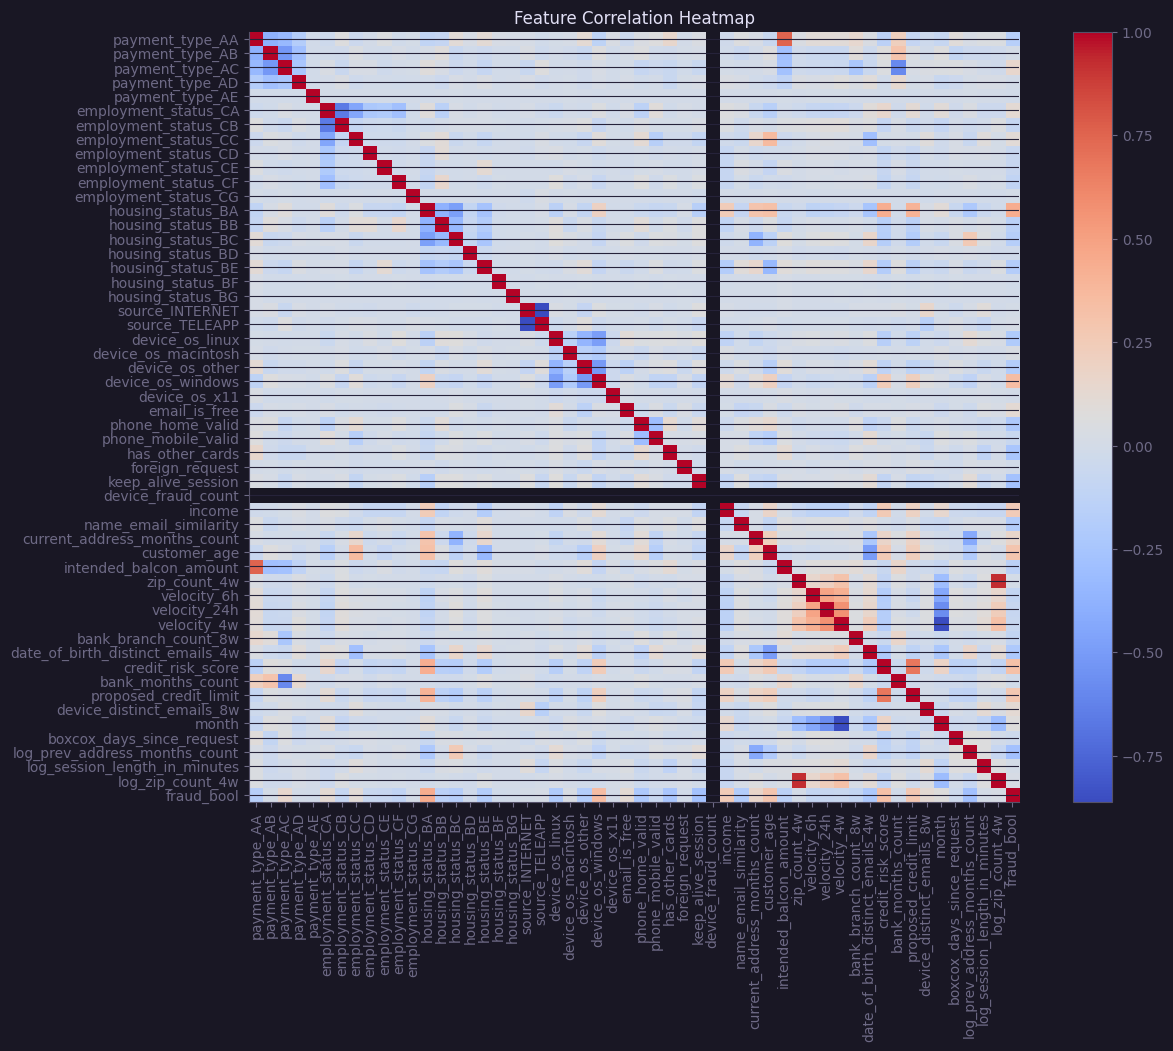

In [99]:
# Calculate the correlation matrix
correlation_matrix = dataset_SMOTE.corr()

# Create a heatmap using matplotlib
plt.figure(figsize=(14, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns),), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns),), correlation_matrix.columns)
plt.title('Feature Correlation Heatmap')
plt.show()


There are varying levels of correlation in the dataset. To quickly identify which are too heavily correlated, the matrix can be flattend to leave feature pairs and correlation value and sorted by value

In [100]:
# Reference column adding to enable the flattening
correlation_matrix['ref'] = correlation_matrix.index

In [101]:
# melt function flattens and values of 1 (the same variable correlation) excluded and sorted
flat_correlation_matrix = correlation_matrix.melt(id_vars='ref')
flat_correlation_matrix[
    (flat_correlation_matrix['value'] != 1) &
    (flat_correlation_matrix['value'] > 0.7)]

,ref,variable,value
37,intended_balcon_amount,payment_type_AA,0.75
1998,payment_type_AA,intended_balcon_amount,0.75
2104,log_zip_count_4w,zip_count_4w,0.92
2846,zip_count_4w,log_zip_count_4w,0.92


This leaves just one correlation pair of payment_type_AA and intended_balcon_amount. Inspecting the data, this correlation seems to come from when payment_type_AA is 0 the intended_balcon_amount is negative and vis versa.

To redunce the dependancy and limit overfitting, payment_type_AA is removed.

In [102]:
# Drop over-correlated feature
dataset_SMOTE.drop(columns = 'payment_type_AA', inplace= True)

### 4.2 Top Contributing Features

Using every feature within a model leads to an overfit and inflexible model. It is therefor advantageous to identify the most impactful features that contribute to predicting fraud, and remove the least useful ones.

#### Mutual Information Feature Selection Method

Mutual Information (MI) Feature Selection is a technique used to identify the most relevant features in a dataset for machine learning. It measures the degree of dependence between a feature and the target variable by calculating the information shared between them. Here's a brief overview of MI Feature Selection and why it's chosen above others:

* Robustness: MI is robust to different data distributions and can handle complex relationships, making it suitable for a wide range of machine learning tasks.
* Feature Independence: It identifies relevant features by assessing their direct impact on the target variable, leading to more accurate model training.
* Interpretability: MI scores are interpretable, allowing data scientists and domain experts to understand the significance of each feature in relation to the target.
* Dimensionality Reduction: MI helps reduce dimensionality by selecting only the most informative features, which can improve model performance and efficiency.
* Balance: It strikes a balance between simplicity and effectiveness, making it a popular choice for feature selection without the need for complex algorithms.

In [104]:
from sklearn.model_selection import train_test_split

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(dataset_SMOTE.drop('fraud_bool', axis=1), dataset_SMOTE['fraud_bool'], test_size=0.2, random_state=0)

In [105]:
X_train.head(5)

,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,keep_alive_session,device_fraud_count,income,name_email_similarity,current_address_months_count,customer_age,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,device_distinct_emails_8w,month,boxcox_days_since_request,log_prev_address_months_count,log_session_length_in_minutes,log_zip_count_4w
1045218,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,1,0,1,0,0,1,0,0.38,0.08,0.13,0.37,0.11,0.41,0.32,0.32,0.48,0.00,0.18,0.47,0.00,0.01,0.67,0.44,0.90,0.00,0.27,0.88
315112,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,1,0,1,0,0,0,0,0.38,1.00,0.45,0.00,0.29,0.16,0.23,0.39,0.57,0.01,0.26,0.59,0.12,0.16,0.67,0.29,0.86,0.92,0.43,0.76
848738,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,1,0,1,1,0,1,0,0.88,0.29,0.33,0.25,0.52,0.20,0.31,0.13,0.37,0.00,0.18,0.57,0.06,0.69,0.67,0.71,0.90,0.00,0.49,0.79
150008,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,1,0,1,0,0,0,0,0.00,0.26,0.07,0.38,0.11,0.38,0.11,0.60,0.53,0.00,0.33,0.70,0.00,0.16,0.67,0.43,0.88,0.00,0.65,0.87
1173519,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,1,0,1,0,0,0,0,0.81,0.30,0.12,0.16,0.11,0.35,0.67,0.43,0.54,0.00,0.42,0.48,0.00,0.25,0.67,0.33,0.97,0.00,0.44,0.85


In [106]:
from sklearn.feature_selection import mutual_info_classif

# Determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)

In [107]:
# Format ouput at series
mutual_info = pd.Series(mutual_info)

# Reset index
mutual_info.index = X_train.columns

# Sort based on output descending
mutual_info_sort = mutual_info.sort_values(ascending = False)

In [108]:
# Reformat to DF for display
mutual_info_sort_pd = pd.DataFrame(mutual_info_sort).reset_index()

# Rename Columns
mutual_info_sort_pd.columns = ['features','values']

# Display top 3 features
mutual_info_sort_pd.head(3)

,features,values
0,credit_risk_score,0.64
1,current_address_months_count,0.64
2,log_zip_count_4w,0.62


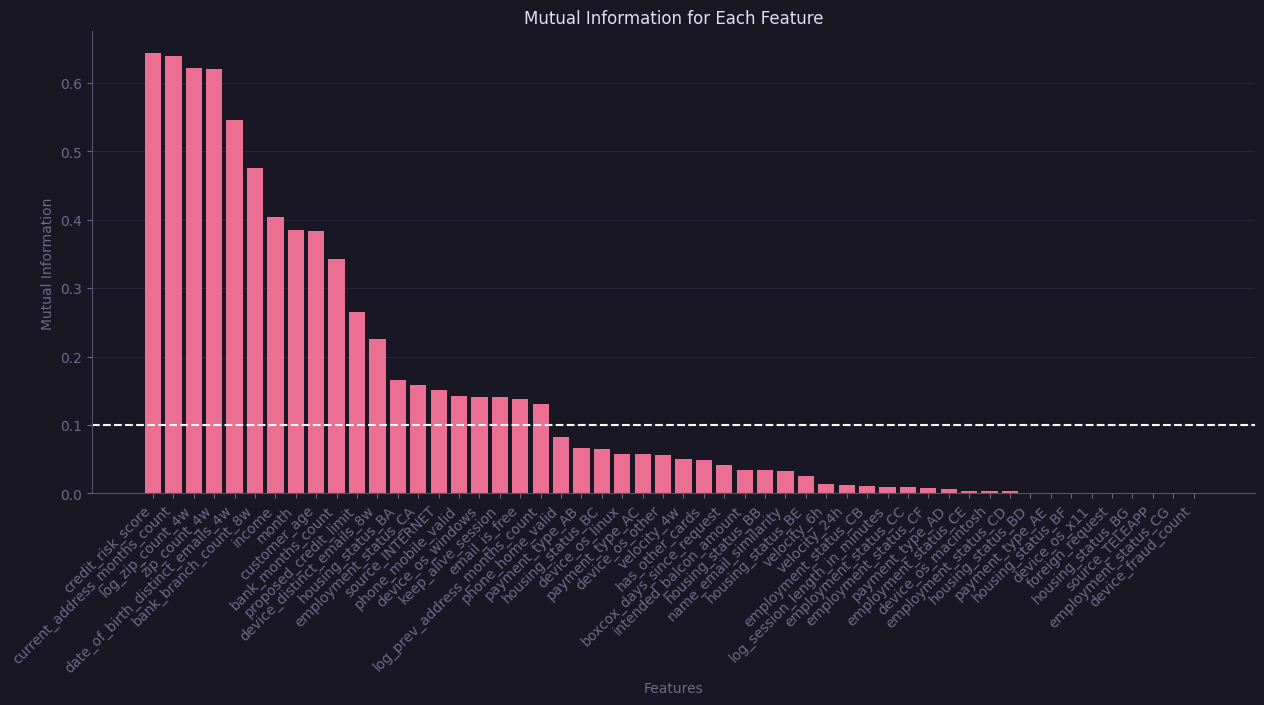

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot all features information index

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(range(len(mutual_info_sort_pd)), mutual_info_sort_pd['values'], align='center')
ax.set_xticks(range(len(mutual_info_sort_pd)))
ax.set_xticklabels(mutual_info_sort_pd['features'], rotation=45, ha='right')  # Use 'feature' column for xtick labels
ax.set_xlabel('Features')
ax.set_ylabel('Mutual Information')
ax.set_title('Mutual Information for Each Feature')

# Add a horizontal line at y = 0.1
ax.axhline(y=0.1, color='white', linestyle='--', label='Threshold: 0.1')

plt.show()


In [212]:
# Display the top features we want to use
top_info_features = mutual_info_sort_pd[mutual_info_sort_pd['values'] > 0.1]['features']

top_info_features

0                    credit_risk_score
1         current_address_months_count
2                     log_zip_count_4w
3                         zip_count_4w
4     date_of_birth_distinct_emails_4w
5                 bank_branch_count_8w
6                               income
7                                month
8                         customer_age
9                    bank_months_count
10               proposed_credit_limit
11           device_distinct_emails_8w
12                   housing_status_BA
13                employment_status_CA
14                     source_INTERNET
15                  phone_mobile_valid
16                   device_os_windows
17                  keep_alive_session
18                       email_is_free
19       log_prev_address_months_count
Name: features, dtype: object

----

# 5. Model Build

The aim is to assess a number of varying models and evaluate differences and performance.

Models:
- Linear Regression
- Random Forest
-  eXtreme Gradient Boosting,
- Artifical Neural Network (ANN)

### 5.1 Data Preparation

Firstly need to split the data into testing and training data. Due to the large dataset a split of 80/20 has been taken.

In [112]:
# Split the data into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(dataset_SMOTE.drop('fraud_bool', axis=1),
                                                    dataset_SMOTE['fraud_bool'],
                                                    test_size=0.2,
                                                    random_state=0)

In [113]:
# Limiting the full dataset to just the feautures outlined
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = X_train[top_info_features]
X_test = X_test[top_info_features]


#### 5.1 Logistic Regression

Logistic regression is a fundamental machine learning algorithm used for binary classification tasks. It works by modeling the relationship between input features and binary outcomes using the sigmoid function. It calculates probabilities, defines a decision boundary, and is trained to find the optimal feature weights to make accurate binary predictions. It is widely used in applications such as spam detection, medical diagnosis, and credit risk assessment.

In [114]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [115]:
# Train the Logistic Regresison model
lr.fit(X_train, y_train)

LogisticRegression()

In [116]:
# Calculate the predictions from text data
lr_pred = lr.predict(X_test)

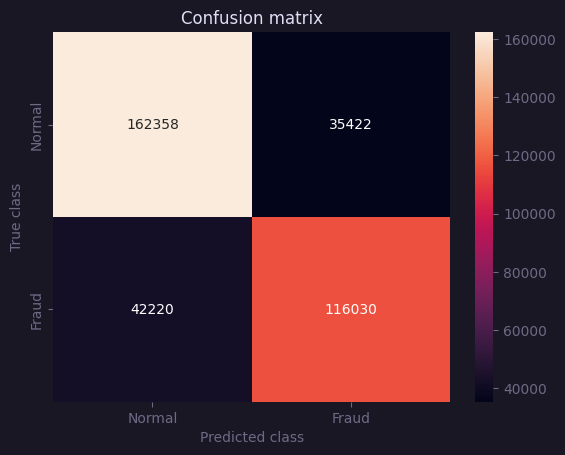

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, auc

LABELS = ['Normal', 'Fraud']

# Construct confusion matric
lr_matrix = confusion_matrix(y_test,lr_pred)
sns.heatmap(lr_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [119]:
# Display performance metrics
print (classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81    197780
           1       0.77      0.73      0.75    158250

    accuracy                           0.78    356030
   macro avg       0.78      0.78      0.78    356030
weighted avg       0.78      0.78      0.78    356030



To evaluate model performance we will use the AUC and ROC Curve.

The AUC is a single scalar value that summarizes the overall performance of a model across different threshold settings. AUC measures the probability that the model will rank a randomly chosen positive example higher than a randomly chosen negative example. It is a useful summary metric, especially when you want to compare models in a straightforward manner. ROC and AUC are less sensitive to class imbalance than other metrics like accuracy. In highly imbalanced datasets, where the majority class dominates, AUC can provide a more meaningful evaluation of the model's ability to separate the classes.

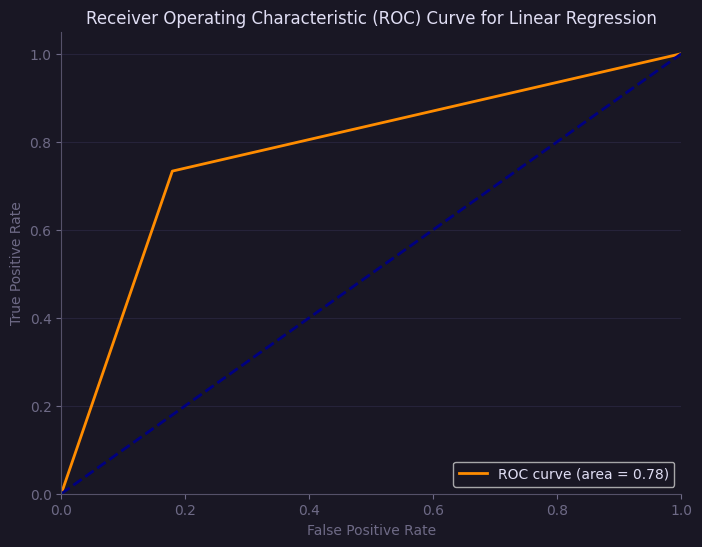

In [120]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, lr_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear Regression')
plt.legend(loc='lower right')
plt.show()

## 5.2 Random Forest

Random Forest is a versatile and powerful ensemble learning algorithm used for both classification and regression tasks. Random Forest works by creating an ensemblarge number le of decision trees through bagging and feature randomization (choosing multiple random subsets of data). It leverages the collective wisdom of multiple trees to make more accurate and stable predictions, making it a popular choice for machine learning tasks where accuracy and generalization are crucial.


![Alt text](image.png)

In [121]:
from sklearn.ensemble import RandomForestClassifier

# Build Random Forrest model
rfc=RandomForestClassifier(max_samples=len(X_train),random_state=1)
rfc.fit(X_train,y_train)


RandomForestClassifier(max_samples=1424117, random_state=1)

In [122]:
# Calculate Predicitions
rf_pred = rfc.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197780
           1       1.00      0.99      0.99    158250

    accuracy                           0.99    356030
   macro avg       0.99      0.99      0.99    356030
weighted avg       0.99      0.99      0.99    356030



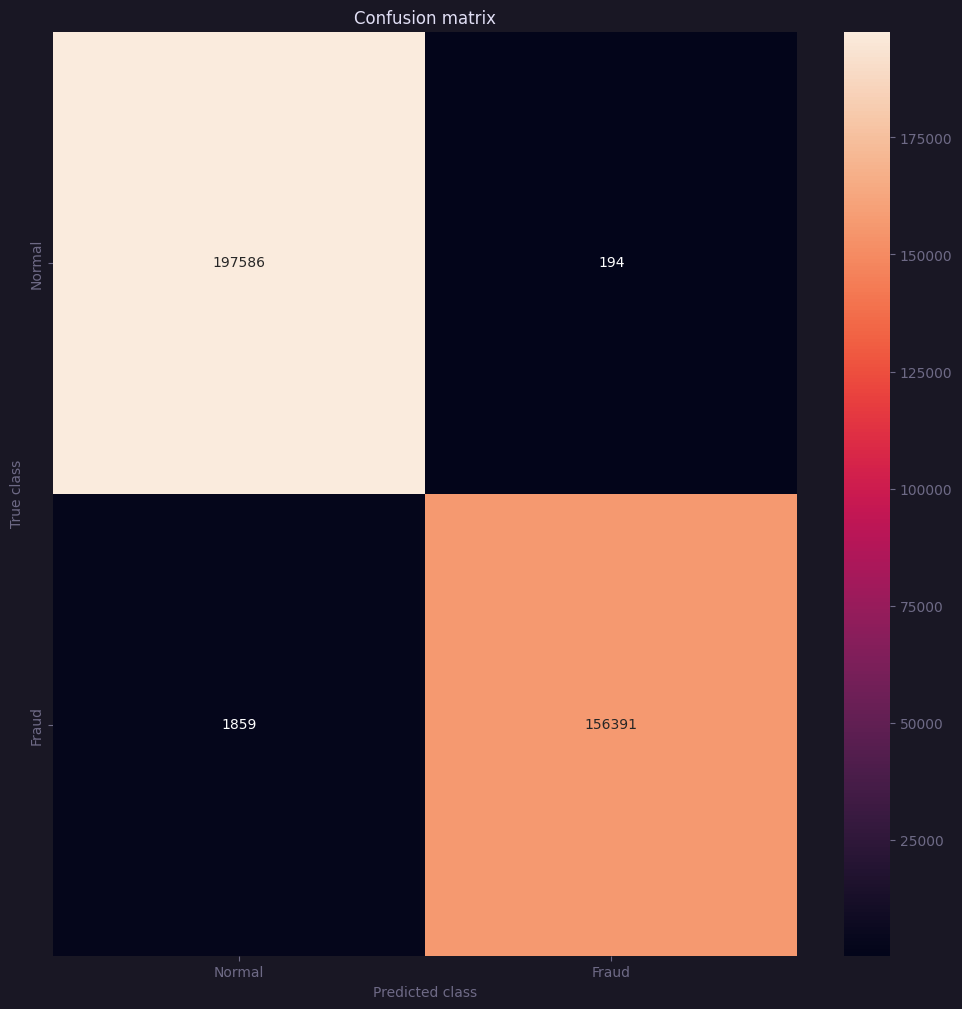

In [124]:
# Display report and confusion matrix
print(classification_report(y_test,rf_pred))

#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

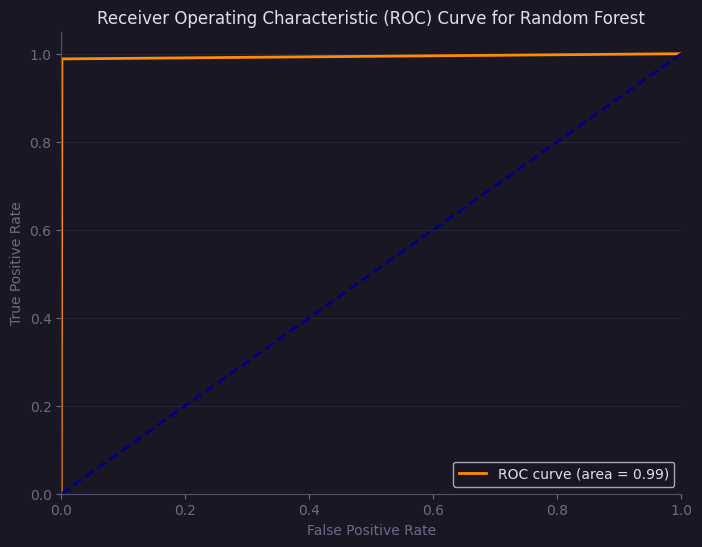

In [125]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

### 5.3 XGBoost Classification

Similar to Random Forest, XGBoost Classification works by iteratively building decision trees to correct the errors of previous predictions, incorporating regularization and feature importance. It is known for its efficiency, speed, and strong predictive capabilities, making it a popular choice for various classification tasks, including those in finance, healthcare, and natural language processing.

While Random Forest is a reliable and straightforward ensemble method, XGBoost is a more advanced and efficient algorithm using inputs from previous trees to guide future choices. Often achieving higher predictive accuracy, especially in structured data tasks. 

In [126]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define function to build model with varying parameters
def xgboost_search(X, y, search_verbose=1):
    params = {
    "gamma":[0.5, 1, 1.5, 2, 5],
    "max_depth":[3,4,5,6],
    "min_child_weight": [100],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)

    grid_search.fit(X, y)

    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

In [127]:
import random
# create subset of rows to speed up search
rows = random.sample(np.arange(0,len(X_train.index)).tolist(), 50000)

# Use search to identify best parameters
model_params = xgboost_search(X_train.iloc[rows,], y_train.iloc[rows,])

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best estimator: 
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=100, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 0.99


In [128]:
# Initiate XGBoost model using best found features
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**model_params)

# Train model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=100, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Model outputs continous numbers, rather than just 1 or 0. This allows for a variable threshold to be used when classifying transactions. In practice, this could allow a user to set the threshold inline with their preference; such as accepting more false positives in the aim to identify more fraud correctly. To check this the threshold is varied and AUC is calculated for each step, the highest AUC is chosen in this instance.

Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

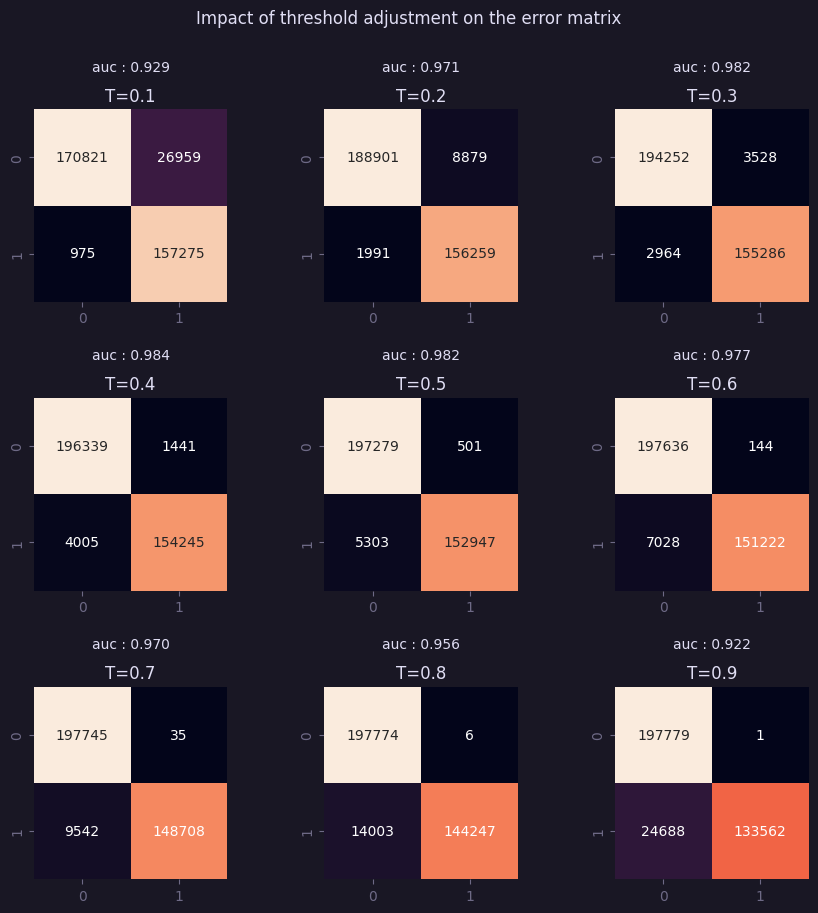

In [129]:
from sklearn import metrics

# Calculate predictions
y_pred_XGB = model.predict_proba(X_test)[:,1]

fig, axes = plt.subplots(3,3, figsize=(10,10))

for t, ax in enumerate(axes.flat): # Cycle through plots
    threshold = (t+1)/10    # Calculate threshold value

    y_pred_XGB_int = (y_pred_XGB > threshold).astype(int)   # calculate classification 1 or 0

    c_matrix = metrics.confusion_matrix(y_test, y_pred_XGB_int) # Create confusion matrix

    sns.heatmap(c_matrix, annot=True, fmt="d", ax=ax, cbar=False) # plot
    ax.title.set_text("T=%.1f" % threshold)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_XGB_int)    
    roc_auc = auc(fpr, tpr)                                     # Calculate auc
    ax.text(1.0, -0.4, "auc : {:.3f}".format(roc_auc), fontsize=10, ha='center')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")

In [130]:
# Choose best threshold and calculate outputs
threshold = 0.4
y_pred_XGB_int = (y_pred_XGB > threshold).astype(int)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    197780
           1       0.99      0.97      0.98    158250

    accuracy                           0.98    356030
   macro avg       0.99      0.98      0.98    356030
weighted avg       0.98      0.98      0.98    356030



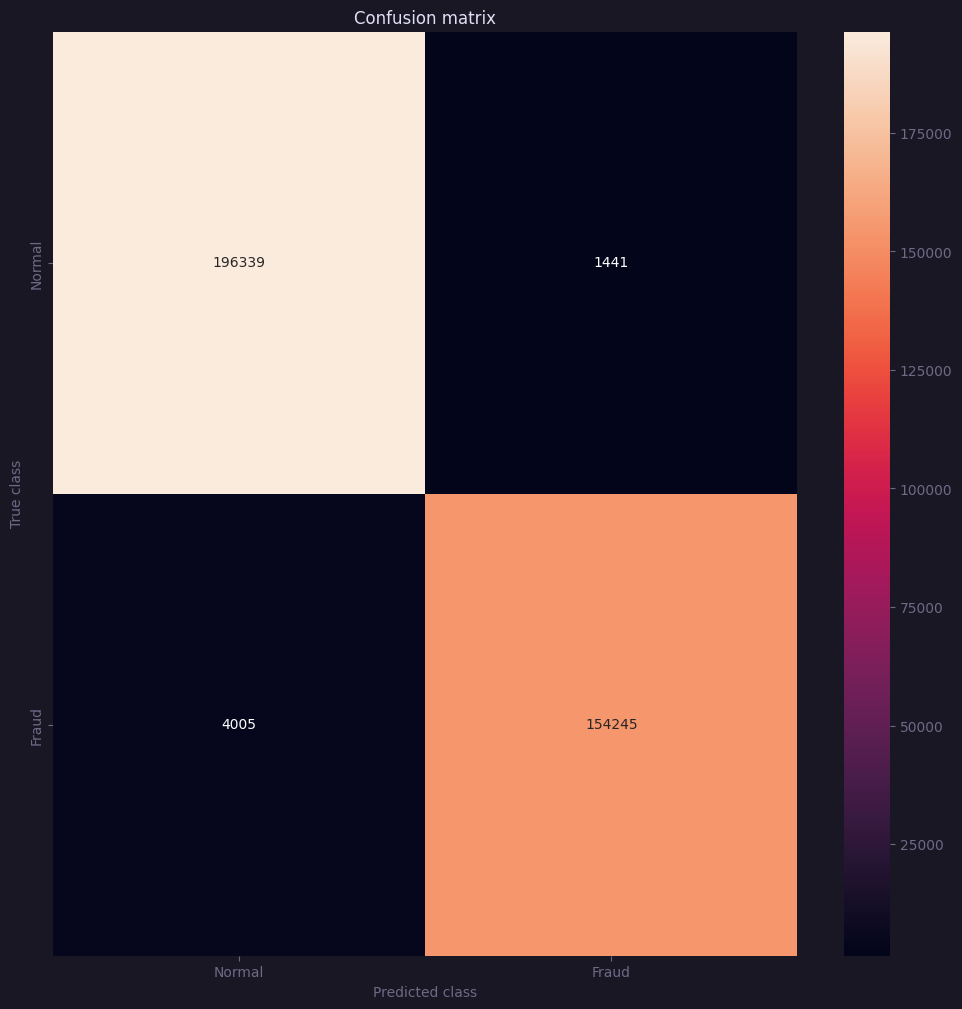

In [131]:
# Print report
print(classification_report(y_test,y_pred_XGB_int))

# Print the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred_XGB_int)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

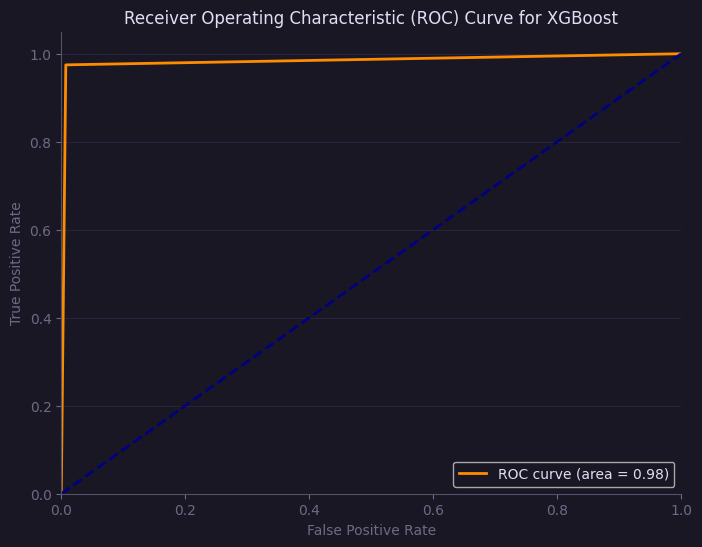

In [132]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_XGB_int)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

Random Forest Visualisation

### 5.4 Artifical Neural Network

An Artificial Neural Network (ANN) for classification operates by processing input data through interconnected layers of neurons. These layers include an input layer representing data features, hidden layers for modeling complex relationships, and an output layer for making predictions. Neurons calculate weighted sums, apply activation functions, and pass information forward through forward propagation. During training, ANNs use optimization techniques to minimize a loss function through backpropagation. Dropout can be used to randomly deactivate a fraction of neurons during each training iteration, preventing overfitting and enhancing model generalization. . This iterative process adjusts the model's parameters, optimizing its ability to match true labels. Once trained, the ANN can make predictions on new data, and its performance is assessed using classification metrics. ANNs are adept at capturing intricate data patterns, making them suitable for a wide array of classification tasks.

Keras Tuner is used to help with parameter tuning. Keras Tuner is an open-source Python library designed to help you automatically optimize and fine-tune deep learning models, particularly those built with Keras, for improved performance. It streamlines the process of hyperparameter tuning by enabling you to efficiently search for the best combination of hyperparameters and model architectures. Keras Tuner provides a simple and scalable API for hyperparameter optimization, allowing you to define the search space, select optimization algorithms, and find the optimal model configuration that maximizes accuracy and generalization for your specific machine learning task. It's a valuable tool for both beginners and experienced data scientists looking to enhance the effectiveness of their deep learning models.

![Alt text](image-2.png)

In [135]:
import numpy as np
from tensorflow import keras
from keras.callbacks import EarlyStopping


# Define function to build model with dynamic parameters
def build_model(hp):

    model_b = []

    hp_units = hp.Int('units', min_value=20, max_value=160, step=20)
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    hp_units_2 = hp.Int('units_2', min_value=0, max_value = 256, step=32)

    model_b = keras.Sequential(
      [
          keras.layers.Dense(units = hp_units, activation="relu", input_shape=(X_train.shape[-1],)),
          keras.layers.Dense(units = hp_units_1, activation="relu"),
          keras.layers.Dropout(0.3),
          keras.layers.Dense(units = hp_units_2, activation="relu"),
          keras.layers.Dropout(0.3),
          keras.layers.Dense(1, activation="sigmoid"),
      ]
    )

    metrics_ = [
    keras.metrics.AUC(name="AUC"),
    keras.metrics.Precision(name="precision")
    #keras.metrics.Recall(name="recall"),
    ]

    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")

    # Compile model
    model_b.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=metrics_,
    )
           

    return model_b

In [136]:
import kerastuner as kt

# initate tuner with parameters
tuner = kt.BayesianOptimization(build_model,
                        objective= kt.Objective('AUC', direction='max'), # Measurment to optimise
                        max_trials = 20,                    # Number if trials
                        overwrite=True,                     # Allow the model to overwrite last
                        directory="MyDirectory",            # Specify name of directory to save
                        project_name='ANN_Classification')            # Specify project name

Using TensorFlow backend


C:\Users\e014694\AppData\Local\Temp\ipykernel_26388\1945299894.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [137]:
rows = random.sample(np.arange(0,len(X_train.index)).tolist(), 100000)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='AUC',  # Monitor auc for early stopping
    patience=3,  # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
) 

# Use tuner to run trials and find best parameters
tuner.search(np.asarray(X_train.iloc[rows,]).astype('float32'),
             np.asarray(y_train.iloc[rows,]).astype('float32'),
             epochs=8,
             callbacks=[early_stopping],
             steps_per_epoch = 10000,
             validation_data=(np.asarray(X_test).astype('float32'),
                                np.asarray(y_test).astype('float32')))


Trial 20 Complete [00h 03m 32s]
AUC: 0.5031934380531311

Best AUC So Far: 0.8832330703735352
Total elapsed time: 01h 01m 52s


{'units': 140, 'units_1': 448, 'units_2': 224, 'lr': 0.000384095574770439}

In [138]:
# Get the best learning rate
best_learning_rate = tuner.get_best_hyperparameters()[0].get('lr')

In [139]:
# Bet the best model built by the tuner
best_hp = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 140)               2940      
                                                                 
 dense_5 (Dense)             (None, 448)               63168     
                                                                 
 dropout_2 (Dropout)         (None, 448)               0         
                                                                 
 dense_6 (Dense)             (None, 224)               100576    
                                                                 
 dropout_3 (Dropout)         (None, 224)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 225       
                                                                 
Total params: 166909 (651.99 KB)
Trainable params: 166

In [140]:
# Specify metric to optimse
metrics_ = [
    keras.metrics.AUC(name="AUC"),
    keras.metrics.Precision(name="precision")
]

# Compile best model from tuner
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_learning_rate), loss="binary_crossentropy", metrics=metrics_,
)

# Fit new model on larger set of data
best_model.fit(
    np.asarray(X_train).astype('float32'),
    np.asarray(y_train).astype('float32'),
    batch_size=1000000,
    epochs=5,
    verbose=2,

)

Epoch 1/5
2/2 - 28s - loss: 0.6832 - AUC: 0.5663 - precision: 0.5478 - 28s/epoch - 14s/step
Epoch 2/5
2/2 - 14s - loss: 0.6640 - AUC: 0.7007 - precision: 0.7130 - 14s/epoch - 7s/step
Epoch 3/5
2/2 - 14s - loss: 0.6451 - AUC: 0.7642 - precision: 0.7613 - 14s/epoch - 7s/step
Epoch 4/5
2/2 - 14s - loss: 0.6259 - AUC: 0.7913 - precision: 0.7654 - 14s/epoch - 7s/step
Epoch 5/5
2/2 - 13s - loss: 0.6061 - AUC: 0.8051 - precision: 0.7614 - 13s/epoch - 7s/step


11126/11126 [==============================] - 11s 959us/step


Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

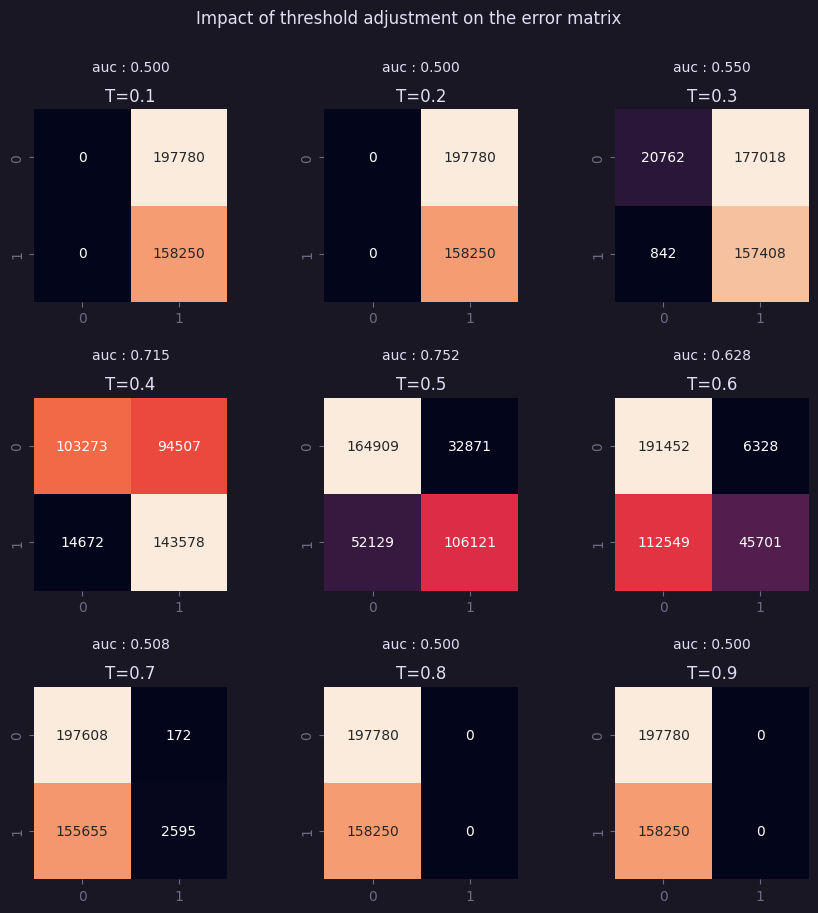

In [141]:
from sklearn import metrics

# Calculate prediction
y_pred_ann_op = best_model.predict(np.asarray(X_test).astype('float32'))

fig, axes = plt.subplots(3,3, figsize=(10,10))

# Use same method to vary threshold to get best result
for t, ax in enumerate(axes.flat):
    threshold = (t+1)/10

    y_pred_ann_op_int = (y_pred_ann_op > threshold).astype(int)
    c_matrix = metrics.confusion_matrix(y_test, y_pred_ann_op_int)
    sns.heatmap(c_matrix, annot=True, fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.1f" % threshold)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_ann_op_int)
    roc_auc = auc(fpr, tpr)
    ax.text(1.0, -0.4, "auc : {:.3f}".format(roc_auc), fontsize=10, ha='center')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")

              precision    recall  f1-score   support

           0       0.88      0.52      0.65    197780
           1       0.60      0.91      0.72    158250

    accuracy                           0.69    356030
   macro avg       0.74      0.71      0.69    356030
weighted avg       0.75      0.69      0.69    356030



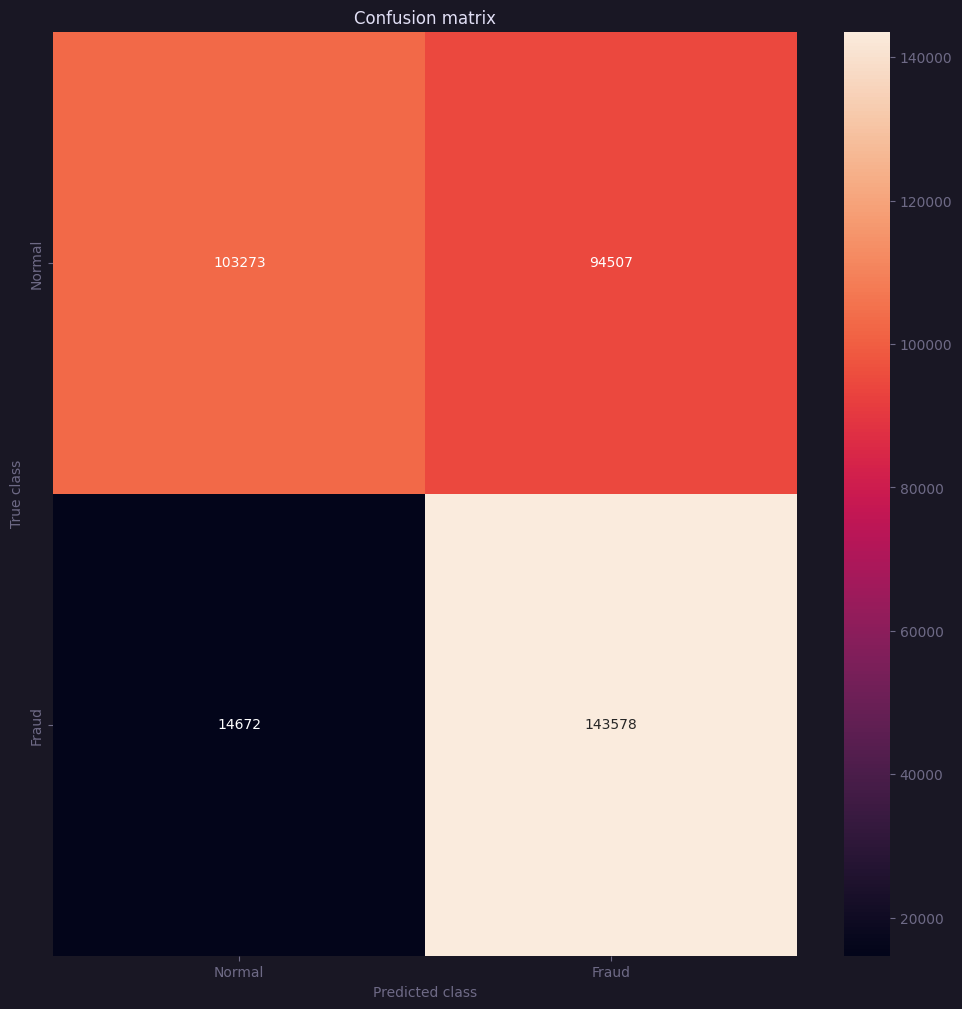

In [142]:
# Input chosen threshold
threshold = 0.4
y_pred_ann_op_int = (y_pred_ann_op > threshold).astype(int)

# Print Report
print(classification_report(y_test,y_pred_ann_op_int))

# Print the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred_ann_op_int)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

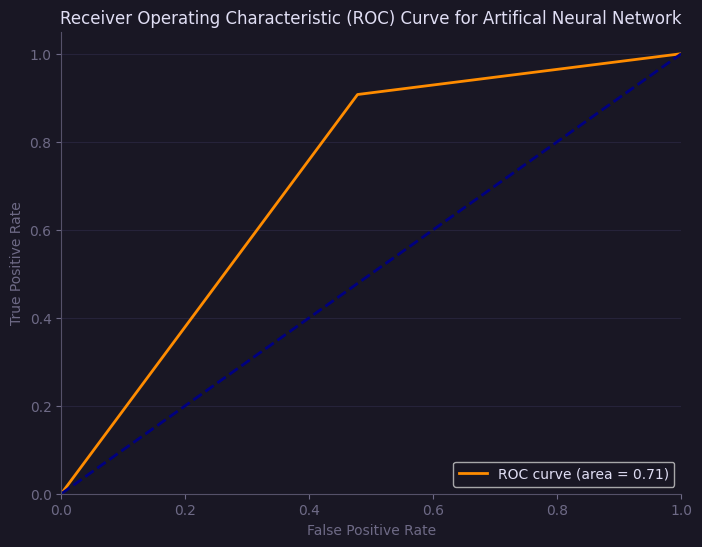

In [143]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ann_op_int)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Artifical Neural Network')
plt.legend(loc='lower right')
plt.show()

--------------------------------

### 6. Comparison 

Adding each graph onto the same plot it's clear random forrest and XGBoost have performed the best providing and AUC of 0.99 and 0.98 It's not surprising both have performed well as they are very similar algorithms, interestingly random forrest performing slightly better than the XGBoost, possibly if the parameters were optimised further better performance could be recieved.

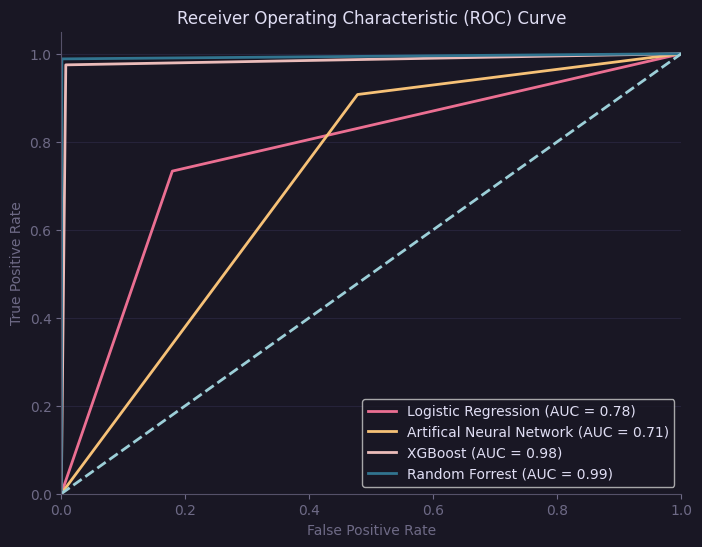

In [144]:
# Calculate the LR curve
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, lr_pred)
roc_auc_LR = auc(fpr_LR, tpr_LR)

# Calculate the ANN curve
fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(y_test, y_pred_ann_op_int)
roc_auc_ANN = auc(fpr_ANN, tpr_ANN)

# Calculate the XGB curve
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test, y_pred_XGB_int)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)

# Calculate the RF curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_LR, tpr_LR, lw=2, label=f'Logistic Regression (AUC = {roc_auc_LR:.2f})')
plt.plot(fpr_ANN, tpr_ANN, lw=2, label=f'Artifical Neural Network (AUC = {roc_auc_ANN:.2f})')
plt.plot(fpr_XGB, tpr_XGB, lw=2, label=f'XGBoost (AUC = {roc_auc_XGB:.2f})')
plt.plot(fpr_rf, tpr_rf,  lw=2, label=f'Random Forrest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [145]:
# Extracting the confusion matrix
conf_matrix = confusion_matrix(y_test, rf_pred)

# Access individual values
true_positive = conf_matrix[1, 1]  # True Positives
true_negative = conf_matrix[0, 0]  # True Negatives
false_positive = conf_matrix[0, 1]  # False Positives
false_negative = conf_matrix[1, 0]  # False Negatives

In [149]:
# Calculate fraction of identified fraud cases for every missed
fraud_rate = true_positive / false_negative

# Calculayte accuracy
accuracy = accuracy_score(y_test, rf_pred)

# Print output
print('1 in every', round(fraud_rate,1), 'fraud cases are missed by the Random Forrest algorithm.')
print('Representing an accuracy rating of', round(accuracy*100,2),'%.')

1 in every 84.1 fraud cases are missed by the Random Forrest algorithm.
Representing an accuracy rating of 99.42 %.


### 7. Conclusion

Overall, achieving an AUC of 0.99 and and accuracy of 99.4% I think is a great success. I've enjoyed improving my understanding of differing models and where their strengths lie. Additional steps could be taken to further improve the random forrest results if ven strong results were required.

These could include:
* Model even more data - the more data that can be put through the model with normally improve results.
* Further feature engineering - Features were assessed and standardised before modelling but evene more time could be spent adjusting the format of features to improve results. Additionally, improvments could be made to the SMOTE data as this wasn't perfect.
* Hyperparameter Tuning - Again, a good amount of time was spent tweaking these parameters but with more time and compute models could continue to be improved for better results.
* Ensemble Methods - Similar to XGBoost, models can be combined or stacked to leverage differing benefits to improve results.


Additionally, with more time I'd like to improve the Neural Network results through further tweaking, but after numerous hours of watching models run knowing it won't top the Random Forrest I thought I'd settle.